In [4]:
import os.path
import types
import math
import yaml
import phacsl.utils.formats.csv_tools as csv_tools
import phacsl.utils.formats.yaml_tools as yaml_tools

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize

def loadCSVByAbbrev(modelDir, fname, key=None):
    if key is None:
        key = 'abbrev'
    fullName = os.path.join(modelDir, fname)
    with open(fullName) as fl:
        keys, recs = csv_tools.parseCSV(fl)
    assert key in keys, ('%s has no "%s" field' % (fullName, key))
    return {rec[key]: rec for rec in recs}

def typeCheck(val):
    return (type(val) in [types.FloatType, types.IntType]) 

modelDir = '/home/welling/git/pyrhea/models/ChicagoLand'

allKeySet, recs = yaml_tools.parse_all(os.path.join(modelDir, 'facilityfacts'))
facDict = {r['abbrev']:r for r in recs}

kL, uRecs = yaml_tools.parse_all(os.path.join(modelDir, 'facilityfactsUpdated'))
updatedFacDict= {r['abbrev']:r for r in uRecs}


In [5]:
isLTACH = [k for k, rec in facDict.items() if rec['category'] in ['LTACH']]


In [6]:
def getVal(abbrev, key):
    if key == 'totalTransfersOut':
        if key in facDict[abbrev]:
            return sum([d['count']['value'] for d in facDict[abbrev][key]])
        else:
            return None
    else:
        if key in facDict[abbrev]:
            return float(facDict[abbrev][key]['value'])
        else:
            return None

def checkPairValid(val, prov):
    for s in ['average', 'median', 'regression', 'slope']:
        if s in prov.lower():
            return False
    if val == 0:
        return False
    return True
    
def checkValid(abbrev, key):
    if key == 'totalTransfersOut':
        for hook in facDict[abbrev][key]:
            if not checkPairValid(hook['value'], hook['prov']):
                return False
        return True
    else:
        hook = facDict[abbrev][key]
        return checkPairValid(hook['value'], hook['prov'])


In [7]:
def findThoseWith(key):
    if key == 'totalTransfersOut':
        return [k for k in isLTACH if key in facDict[k]]
    else:
        return [k for k in isLTACH if key in facDict[k] and typeCheck(facDict[k][key]['value'])]


In [8]:
def findThoseWithout(key):
    l = findThoseWith(key)
    return [k for k in isLTACH if k not in l]

In [9]:
def findThoseWithoutValid(key):
    noneL = findThoseWithout(key)
    withL = findThoseWith(key)
    fakeL = [k for k in withL if not checkValid(k, key)]
    return noneL + fakeL


In [10]:
def findThoseWithValid(key):
    withL = findThoseWith(key)
    validL = [k for k in withL if checkValid(k, key)]
    return validL


In [11]:
s1 = set(findThoseWithValid('fracAdultPatientDaysICU'))
s2 = set(findThoseWithoutValid('fracAdultPatientDaysICU'))
hospSet = set(isLTACH)
print s1.intersection(s2)
print hospSet == s1.union(s2)


set([])
True


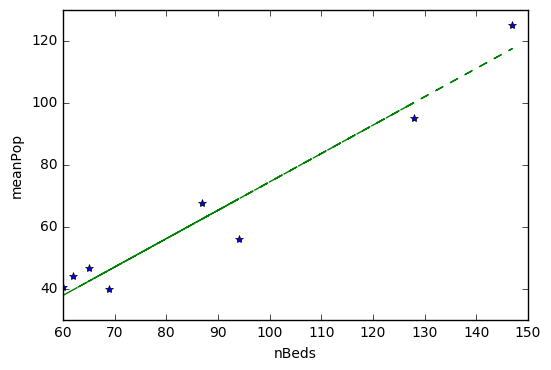

slope: 0.915393514265
intercept: -17.1672830436
std_err: 0.0896885497054
r_value: 0.972388088035
p_value: 5.1545642312e-05
----------------------
VIBR_9509_L, 19.448458,


In [14]:
depKey = 'meanPop'
lDep = findThoseWithValid(depKey)
indepKey = 'nBeds'
lIndep = findThoseWithValid(indepKey)
workL = [k for k in lIndep if k in lDep]
xL = [getVal(k, indepKey) for k in workL]
yL = [getVal(k, depKey) for k in workL]
slope, intercept, r_value, p_value, std_err = stats.linregress(xL,yL)
yFit = [intercept + (x * slope) for x in xL]
plt.xlabel(indepKey)
plt.ylabel(depKey)
plt.plot(xL, yL, '*')
plt.plot(xL, yFit, '--')
plt.show()
print 'slope: %s' % slope
print 'intercept: %s' % intercept
print 'std_err: %s' % std_err
print 'r_value: %s' % r_value
print 'p_value: %s' % p_value
print '----------------------'
targetL = findThoseWithoutValid(depKey)
targetL.sort()
for abbrev in targetL:
    if abbrev in findThoseWithValid(indepKey):
        print '%s, %f,' % (abbrev, (slope*(getVal(abbrev,indepKey)) + intercept))
    else:
        print '%s,,no %s' % indepKey

In [ ]:
def innerTermCompare(oldTerm, newTerm, preamble=None):
    if preamble is None:
        preamble = ''
    # print '%s %s -> %s' % (preamble, oldTerm, newTerm)
    if isinstance(oldTerm, types.DictType):
        if isinstance(newTerm, types.DictType):
            allKeys = set(newTerm.keys() + oldTerm.keys())
            for key in allKeys:
                if key in oldTerm:
                    if key in newTerm:
                        if newTerm[key] != oldTerm[key]:
                            newPreamble = '%s %s: ' % (preamble, key)
                            innerTermCompare(oldTerm[key], newTerm[key], preamble=newPreamble)
                    else:
                        print '%s %s: this key was deleted' % (preamble, key)
                elif key in newTerm:
                    print '%s %s: this key was added' % (preamble, key)
                else:
                    raise RuntimeError('Vanishing key %s' % key)
        else:
            print '%s%s -> %s' % (preamble, oldTerm, newTerm)
    elif isinstance(oldTerm, types.ListType):
        if isinstance(newTerm, types.ListType):
            oldL = oldTerm[:]
            oldL.sort()
            newL = newTerm[:]
            newL.sort()
            idx = 0
            while oldL and newL:
                innerTermCompare(oldL.pop(0), newL.pop(0), preamble='%s %s:'%(preamble, idx))
                idx += 1
            if oldL:
                print '%s: lost %s in update' % (preamble, oldL)
            elif newL:
                print '%s: gained %s in update' % (preamble, newL)
            else:
                pass  # lists have been compared
        else:
            print '%s%s -> %s' % (preamble, oldTerm, newTerm)
    else:
        if oldTerm != newTerm:
            print '%s%s -> %s' % (preamble, oldTerm, newTerm)


    
def termCompare(abbrev, key):
    if abbrev in facDict:
        if abbrev in updatedFacDict:
            if key in facDict[abbrev]:
                if key in updatedFacDict[abbrev]:
                    oldTerm = facDict[abbrev][key]
                    newTerm = updatedFacDict[abbrev][key]
                    if newTerm != oldTerm:
                        innerTermCompare(oldTerm, newTerm, '%s: %s: ' % (abbrev, key))
                else:
                    pass
            else:
                if key in updatedFacDict[abbrev]:
                    print '%s: %s field was added in update' % (abbrev, key)
                else:
                    pass # no such abbrev key pair exists
        else:
            pass  # This abbrev was not updated
    elif abbrev in updatedFacDict:
        print '%s record was newly created in the update' % abbrev
    else:
        pass  # no such entry exists
        
allKeySet, recs = yaml_tools.parse_all(os.path.join(modelDir, 'facilityfacts'))
facDict = {r['abbrev']:r for r in recs}

kL, uRecs = yaml_tools.parse_all(os.path.join(modelDir, 'facilityfactsUpdated'))
updatedFacDict= {r['abbrev']:r for r in uRecs}

for abbrev, rec in facDict.items():
    if abbrev in updatedFacDict:
        uRec = updatedFacDict[abbrev]
        allKeys = set(rec.keys() + uRec.keys())
        for key in allKeys:
            if key in rec:
                if key in uRec:
                    termCompare(abbrev, key)
                else:
                    print '%s: no %s in updated rec' % (abbrev, key)
            else:
                print '%s: %s key was added' % (abbrev, key)

print '----DONE----'


In [21]:
print findThoseWithoutValid('meanLOSICU')
print isLTACH

['RML_5601_L', 'THC_2544_L', 'ADVO_3435_L', 'THC_365_L', 'THC_4058_L', 'PRES_100_L', 'THC_225_L', 'VIBR_9509_L', 'THC_6130_L']
['RML_5601_L', 'THC_2544_L', 'ADVO_3435_L', 'THC_365_L', 'THC_4058_L', 'PRES_100_L', 'THC_225_L', 'VIBR_9509_L', 'THC_6130_L']


In [20]:
l1 = findThoseWithoutValid('meanPop')
l2 = findThoseWithValid('nBeds')
for abbrev in l1:
    print '%s: %s' % (abbrev, facDict[abbrev]['address'])


VIBR_9509_L: 9509 GEORGIA ST, CROWN POINT, Lake County, IN 46307, USA


In [13]:
for abbrev in findThoseWithoutValid('meanPop'):
    print '%s: %s' % (abbrev, getVal(abbrev, 'meanPop'))

VIBR_9509_L: None
